Welcome to Homework 2! The goal of this homework is for you to implement gradient boosted trees from scratch, to gain a deep appreciation for how the method works. To do this, you'll be able to use `DecisionTreeRegressor` in `sklearn`, but you won't be able to use the classes `GradientBoostingRegressor` or `GradientBoostingClassifier`.

Then you'll apply this to the dataset "Smoker Status Prediction using Bio-Signals" on Kaggle https://www.kaggle.com/datasets/gauravduttakiit/smoker-status-prediction-using-biosignals

Q1: Consider the task of training a gradient boosted tree to predict a binary outcome. Provide the mathematical definition of a gradient boosted tree $f$ with respect to a collection of regression trees $g_i$ for $i = 1,\cdots, t$. Specify what quantity the gradient boosted tree predicts (i.e. probability, log odds, odds, etc). (10 points)

**Gradient-boosted tree (binary logistic loss)**  


$$
f_t(x) \;=\; \beta_0 \;+\; \sum_{i=1}^{t} \eta_i\, g_i(x)
$$

---

* $\beta_0$ – initial score (log-odds of the base rate)  
* $g_i(x)$ – regression trees  
* $\eta_i$ – learning-rate coefficients

**What the model predicts**

Raw score (log-odds):  

$$
f_t(x) \;=\; \log\!\Bigg(\frac{\Pr(Y=1\mid x)}{\Pr(Y=0\mid x)}\Bigg)
$$

Convert to class probability with the sigmoid:  

$$
\hat{p}(x) \;=\; \sigma\!\bigl(f_t(x)\bigr) \;=\; \frac{1}{1 + e^{-f_t(x)}}.
$$

Q2: As in logistic regression, we will use the cross-entropy loss (aka the negative log likelihood). Provide the objective function $L(f)$ for a gradient boosted tree $f$ that outputs a probability at any observation $x$ and a dataset of $n$ IID observations. (10 points)

**Cross-entropy loss for a gradient-boosted tree that outputs probabilities**

$$
L(f)
\;=\;
-\;\frac{1}{n}\sum_{i=1}^{n}
\Bigl[
    y_i \,\log\!\bigl(\hat p_i\bigr)
    \;+\;
    (1-y_i)\,\log\!\bigl(1-\hat p_i\bigr)
\Bigr],
\quad\text{where } \hat p_i = f(x_i), \text{ the predicted probability for sample i.}
$$

Q3: Given a gradient boosted tree at iteration $t$, i.e. $f_t$, what is the gradient of the objective function with respect to $f_t$? That is, what is the gradient that we aim to approximate in the next iteration of the fitting procedure? Derive it step by step. (10 points)

We define:
$p_{t,i} = \sigma(f_t(x_i)) = \frac{1}{1+e^{-f_t(x_i)}}$

The loss at iteration $t$ is:
$$L_t = -\sum_{i=1}^{n} \left[ y_i \log p_{t,i} + (1-y_i)\log(1-p_{t,i}) \right]$$

#### Step 1: Find derivative w.r.t. probability
$$\frac{\partial L_t}{\partial p_{t,i}} = -\left(\frac{y_i}{p_{t,i}} - \frac{1-y_i}{1-p_{t,i}}\right)$$

#### Step 2: Find derivative of probability w.r.t. score
$$\frac{\partial p_{t,i}}{\partial f_{t,i}} = p_{t,i}(1-p_{t,i})$$

#### Step 3: Apply chain rule 

$$\frac{\partial L_t}{\partial f_{t,i}} = \frac{\partial L_t}{\partial p_{t,i}} \cdot \frac{\partial p_{t,i}}{\partial f_{t,i}} = (p_{t,i}-y_i)$$

We therefore find the gradient of the loss with respect to the model score $f_{t,i}$ is:

$$\frac{\partial L_t}{\partial f_{t,i}} = (p_{t,i}-y_i)$$

#### Step 4: Pseudo-residual we fit in next iteration
$$r_{t,i} = y_i - p_{t,i}$$

Q4: Write a python function that fits a regression tree $g_{t+1}$ to estimate the gradient with respect to $f_t$. This function should take in the gradient, the features $x$, and max tree depth. (5 points)

In [2]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor

def fit_gradient_tree(X, gradients, max_depth=3, subsample=1.0, random_state=0):
    """
    Train the (t+1)-st regression tree g_{t+1} to approximate the
    negative gradient / pseudo-residuals.

    Parameters
    ----------
    X : array-like, shape (n_samples, n_features)
        Feature matrix.
    gradients : array-like, shape (n_samples,)
        Targets = y_i − p_{t,i}   (or equivalently −∂L/∂f_t).
    max_depth : int, default=3
        Depth limit for the DecisionTreeRegressor (as in Lab 3).
    subsample : float in (0,1], default=1.0
        If <1, draw a random fraction of rows *without* replacement
        before fitting (analogue of the bootstrap in Lab 4).
    random_state : int, default=0
        Ensures reproducibility of both the subsample and the tree split-finding.

    Returns
    -------
    tree : sklearn.tree.DecisionTreeRegressor
        Trained regression tree g_{t+1}.
    """
    rng = np.random.default_rng(random_state)

    # --- (optional) row subsampling like the RF bootstrap in Lab 4 ---
    if subsample < 1.0:
        n_rows = X.shape[0]
        keep = rng.choice(n_rows, int(subsample * n_rows), replace=False)
        X_fit, y_fit = X[keep], gradients[keep]
    else:
        X_fit, y_fit = X, gradients

    # --- fit the regression tree exactly as in Lab 3’s Elastic-Net example ---
    tree = DecisionTreeRegressor(max_depth=max_depth, random_state=random_state)
    tree.fit(X_fit, y_fit)

    return tree

Q5: Using the python function you defined in Q4, write a python function that fits a gradient boosting tree. The function should take in as arguments the max tree depth, the number of iterations, the training data, and the learning rate. The function should output your gradient boosted tree and the auc on the training data at each iteration. (20 points)

In [3]:
import os
import datetime as dt
import pandas as pd
import numpy as np
from scipy.special import expit
from sklearn.metrics import roc_auc_score

def fit_gradient_boosting(
        X, y,
        n_iters=100,
        max_depth=3,
        learning_rate=0.1,
        subsample=1.0,
        random_state=0,
        save_csv=True):
    """
    Train GBT and optionally save the per-iteration AUC to
    `q5 data/auc_<timestamp>.csv`.

Train a gradient-boosted tree ensemble for binary classification.

    Parameters
    ----------
    X : array (n_samples, n_features)
    y : array (n_samples,)  with 0/1 targets
    n_iters : int           number of boosting rounds
    max_depth : int         depth for each regression tree
    learning_rate : float   shrinkage parameter (η)
    subsample : float       row-sampling fraction per tree (like RF bootstrap)
    random_state : int      reproducibility seed

    Returns
    -------
    model : dict
        {'trees': list_of_fitted_trees,
         'learning_rate': η,
         'initial_score': f0}
    train_auc_history : list of float
        AUC on the training data after each boosting round.


    
    """
    # ----- initial log-odds score  f0  (use logit of class prior) -----

    rng = np.random.default_rng(random_state)
    prior = np.clip(y.mean(), 1e-8, 1-1e-8)
    f = np.full_like(y, np.log(prior/(1-prior)), dtype=float)

    trees, auc_hist = [], []

    for t in range(n_iters):
        # 1. Compute pseudo-residuals  r_{t,i} = y_i − p_{t,i}
        p = expit(f)
        residuals = y - p
        # 2. Fit regression tree on residuals
        tree_seed = rng.integers(1e9)
        tree = fit_gradient_tree(X, residuals,
                                 max_depth=max_depth,
                                 subsample=subsample,
                                 random_state=tree_seed)
        trees.append(tree)
        # 3. Update score
        f += learning_rate * tree.predict(X)
        # 4. Compute AUC
        auc = roc_auc_score(y, expit(f))
        auc_hist.append(auc)

    model = {'trees': trees,
             'learning_rate': learning_rate,
             'initial_score': np.log(prior/(1-prior))}

    # --- optional: persist history to CSV ----------------------------------
    csv_path = None
    if save_csv:
        os.makedirs("q5 data", exist_ok=True)
        timestamp = dt.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
        csv_path = f"q5 data/auc_{timestamp}.csv"
        pd.DataFrame({
            'iteration': np.arange(1, n_iters+1),
            'train_auc': auc_hist
        }).to_csv(csv_path, index=False)

    return model, auc_hist, csv_path  # csv_path is None if save_csv=False


def predict_proba_gbt(model, X):
    f = np.full(X.shape[0], model['initial_score'])
    for tree in model['trees']:
        f += model['learning_rate'] * tree.predict(X)
    return expit(f)

Q6: Load in the dataset. Split 75% of the data for training and the rest for testing. (5 points)

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split

# 1. Load data
df = pd.read_csv("/Users/anyadecarlo/datasci_224/Data/hw2_train_dataset.csv")

# 2. Separate features and outcome
y = df["smoking"]            # binary outcome
X = df.drop(columns="smoking")

# 3. 75 / 25 split (stratified to keep class balance)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

print(f"Train shape: {X_train.shape}   Test shape: {X_test.shape}")
print("Class balance in train:", y_train.mean(), "| test:", y_test.mean())

Train shape: (29238, 22)   Test shape: (9746, 22)
Class balance in train: 0.36729598467747454 | test: 0.36722758054586496


Q7: Apply your gradient boosted tree to this dataset. Plot the training auc over each iteration. (5 points)

AUC history saved to: q5 data/auc_2025-04-28_23-41-49.csv
Final training AUC after 200 rounds: 0.8299


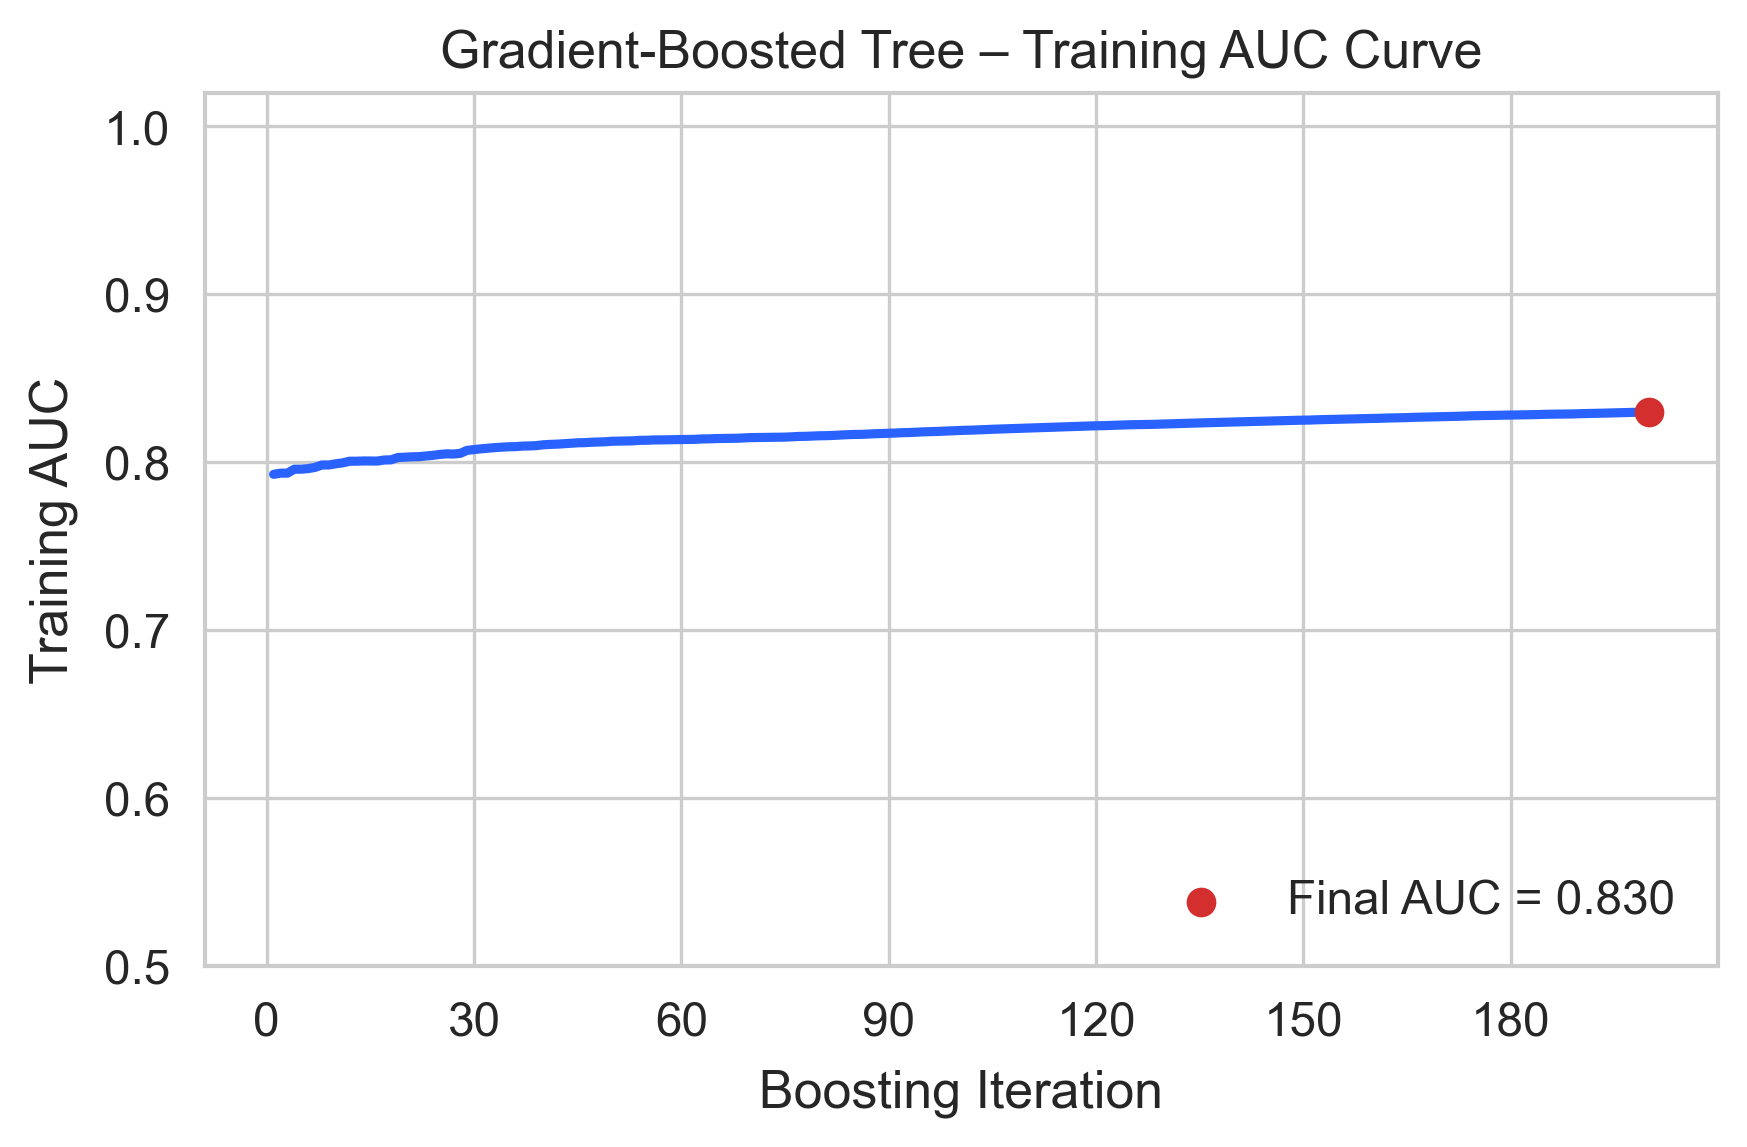

In [5]:
# ============================================
#  Gradient-Boosted Tree | Training-AUC curve
# ============================================
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator  # integer ticks
sns.set_theme(style="whitegrid", context="paper", font_scale=1.3)

# ---------- training ----------
N_ITERS      = 200     
MAX_DEPTH    = 3
LEARNINGRATE = 0.1

model, auc_hist, csv_path = fit_gradient_boosting(
    X_train.values,           # ensure numpy array for speed
    y_train.values,
    n_iters=N_ITERS,
    max_depth=MAX_DEPTH,
    learning_rate=LEARNINGRATE,
    save_csv=True,            # writes q5 data/auc_<timestamp>.csv
    random_state=42
)

print(f"AUC history saved to: {csv_path}")
print(f"Final training AUC after {N_ITERS} rounds: {auc_hist[-1]:.4f}")

# ---------- high-quality plot ----------
fig, ax = plt.subplots(figsize=(6, 4), dpi=300)
sns.lineplot(x=range(1, N_ITERS + 1), y=auc_hist,
             ax=ax, linewidth=2.2, color="#2962FF")

# highlight final point
ax.scatter(N_ITERS, auc_hist[-1], color="#D32F2F", zorder=3,
           s=40, label=f"Final AUC = {auc_hist[-1]:.3f}")

# cosmetics
ax.set_xlabel("Boosting Iteration", labelpad=6)
ax.set_ylabel("Training AUC", labelpad=6)
ax.set_title("Gradient-Boosted Tree – Training AUC Curve")
ax.xaxis.set_major_locator(MaxNLocator(integer=True, nbins=8))
ax.set_ylim(0.5, 1.02)          # assumes binary AUC
ax.legend(frameon=False, loc="lower right")
fig.tight_layout()

# save high-resolution outputs
fig.savefig("train_auc_gbt.png", dpi=300, bbox_inches="tight")
fig.savefig("train_auc_gbt.pdf", bbox_inches="tight")
plt.show()

Q8: What is the AUC of your gradient boosted tree on the test data? (5 points)

In [6]:
from sklearn.metrics import roc_auc_score
import numpy as np
from sklearn.metrics import roc_auc_score

# --- Q8: test-set AUC ---------------------------------------------
proba_test = predict_proba_gbt(model, X_test.values)  # class-1 probabilities
test_auc  = roc_auc_score(y_test, proba_test)

# ----------------------------------------------------------
# point estimate on the held-out data
proba_test = predict_proba_gbt(model, X_test.values)   # X_test is a DataFrame
test_auc   = roc_auc_score(y_test, proba_test)

# ----------------------------------------------------------
# bootstrap 95 % confidence interval to quanitfy uncertainity due to sampling variability 
n_test    = len(y_test)
boot_aucs = []

for _ in range(1000):                        # 1000 resamples
    idx = np.random.choice(n_test, n_test, replace=True)
    boot_auc = roc_auc_score(
        y_test.values[idx],                  # labels in resample
        predict_proba_gbt(model, X_test.values[idx])  # probs in resample
    )
    boot_aucs.append(boot_auc)

# “bias-corrected” style you used in Lab 3
diff_q = np.quantile(test_auc - np.array(boot_aucs), q=[0.025, 0.975])
ci_low, ci_high = test_auc + diff_q[0], test_auc + diff_q[1]

print(f"Test AUC         : {test_auc:.4f}")
print(f"95% bootstrap CI : ({ci_low:.4f}, {ci_high:.4f})")

Test AUC         : 0.8221
95% bootstrap CI : (0.8146, 0.8301)


In [ ]:
import nbformat
import nbconvert

# Load the notebook
with open('HW2.ipynb') as f:
    nb = nbformat.read(f, as_version=4)

# Use normalize function to add missing cell IDs
from nbformat import validate, ValidationError
try:
    validate(nb)
except ValidationError as e:
    print(f"Validation error: {e}")

# Convert to HTML
html_exporter = nbconvert.HTMLExporter()
html_data, resources = html_exporter.from_notebook_node(nb)

# Write to file with your name
with open('AnyaDeCarloHW2.html', 'w') as f:
    f.write(html_data)